# Attack Tests remade (23.01.26)

In [41]:
import warnings
warnings.filterwarnings('ignore')
import os
from keras.models import load_model
import tensorflow as tf
import tensorflow_datasets as tfds

from art import config
from art.utils import load_dataset, get_file
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod
from art.attacks.evasion import BasicIterativeMethod
from art.defences.trainer import AdversarialTrainer
from art.defences.trainer import AdversarialTrainerMadryPGD
from art.estimators.classification import KerasClassifier

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

#### Import Models

In [33]:
folder_path = 'assets/models_mu/'
adv_models_mu = {}
for adv_model in os.listdir(folder_path):
    if '.h5' in adv_model:
        id = adv_model.split('_')[-1].split('.')[0]
        adv_models_mu[id] = load_model(folder_path + adv_model)

folder_path = 'assets/models_mu_transform/'
adv_models_mu_transform = {}
for adv_model in os.listdir(folder_path):
    if '.h5' in adv_model:
        id = adv_model.split('_')[-1].split('.')[0]
        adv_models_mu_transform[id] = load_model(folder_path + adv_model)

In [34]:
adv_models_mu = dict(sorted(adv_models_mu.items()))
adv_models_mu_transform = dict(sorted(adv_models_mu_transform.items()))

In [4]:
model = tf.keras.models.load_model('assets/models/mnist_zico.h5')
model_madry = tf.keras.models.load_model('assets/models/mnist_madry_zico_model.h5')
model_adv = tf.keras.models.load_model('assets/models/mnist_adv_model.h5')
model_adv_v2 = tf.keras.models.load_model('assets/models/mnist_adv_model_v2.h5')
model_adv_v3 = tf.keras.models.load_model('assets/models/mnist_adv_model_v3.h5')
model_adv_v3_2 = tf.keras.models.load_model('assets/models/mnist_adv_model_v3_2.h5')
model_adv_v4 = tf.keras.models.load_model('assets/models/mnist_adv_model_v4.h5')
model_adv_v5 = tf.keras.models.load_model('assets/models/mnist_adv_model_v5.h5')
model_adv_v6 = tf.keras.models.load_model('assets/models/mnist_adv_model_v6.h5')
model_adv_v6 = tf.keras.models.load_model('assets/models/mnist_adv_model_v6.h5')
# model_final = tf.keras.models.load_model('research/models/mnist_adv_model_final.h5')

## Import Data

### MNIST

In [3]:
(x_art_train, y_art_train), (x_art_test, y_art_test), min_, max_ = load_dataset('mnist')

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [5]:
# resize x_train and x_test
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [6]:
# load mnist
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_images = train_images / 255.0
test_images = test_images / 255.0

num_classes = 10

### PGD, FGSM and SPSA Images

In [4]:
# load fgsm and pgd images and labels
# import fgsm and pgd adversarial sampels
pgd_images_zico = np.load('assets/pgd_images_zico.npz')['images']
pgd_labels_zico = np.load('assets/pgd_images_zico.npz')['labels']
pgd_labels_zico_onehot = np.take(np.eye(10, dtype=np.float32), pgd_labels_zico, axis=0)

fgsm_images_zico = np.load('assets/fgsm_images_zico.npz')['images']
fgsm_labels_zico = np.load('assets/fgsm_images_zico.npz')['labels']
fgsm_labels_zico_onehot = np.take(np.eye(10, dtype=np.float32), fgsm_labels_zico, axis=0)

spsa_images_zico = np.load('assets/spsa_images_zico.npz')['images']
spsa_labels_zico = np.load('assets/spsa_images_zico.npz')['labels']
spsa_labels_zico_onehot = np.take(np.eye(10), spsa_labels_zico.astype(np.int64), axis=0)

# reshape pgd and fgsm images to 28, 28, 1
pgd_images_zico = np.reshape(pgd_images_zico, (len(pgd_images_zico), 28, 28, 1))
fgsm_images_zico = np.reshape(fgsm_images_zico, (len(fgsm_images_zico), 28, 28, 1))
spsa_images_zico = np.reshape(spsa_images_zico, (len(spsa_images_zico), 28, 28, 1))

print(pgd_images_zico.shape)
print(pgd_labels_zico.shape)
print(fgsm_images_zico.shape)
print(fgsm_labels_zico.shape)   
print(spsa_images_zico.shape)
print(spsa_labels_zico.shape)

(140000, 28, 28, 1)
(140000, 1)
(140000, 28, 28, 1)
(140000, 1)
(400, 28, 28, 1)
(400, 1)


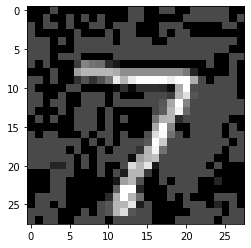

[[    0     1     2     3     4     5     6     7     8     9]
 [13720 15890 14448 14140 13748 12488 13412 14392 13636 14126]]


In [5]:
plt.imshow(fgsm_images_zico[10000], cmap='gray')
plt.show()

# show the first 1000 unique labels and counts
unique, counts = np.unique(fgsm_labels_zico, return_counts=True)
print(np.asarray((unique, counts)))

# take the first 10000 labels and images because higher epsilon values make the image unrecognizable
fgsm_images_zico = fgsm_images_zico[:10000]
fgsm_labels_zico = fgsm_labels_zico[:10000]
fgsm_labels_zico_onehot = fgsm_labels_zico_onehot[:10000]

# squeeze fgsm_labels_zico and pgd_labels_zico to remove the extra dimension
fgsm_labels_zico = np.squeeze(fgsm_labels_zico)
fgsm_labels_zico_onehot = fgsm_labels_zico_onehot.reshape(-1, 10)
pgd_labels_zico = np.squeeze(pgd_labels_zico)
pgd_labels_zico_onehot = pgd_labels_zico_onehot.reshape(-1, 10)
spsa_labels_zico = np.squeeze(spsa_labels_zico)
spsa_labels_zico_onehot = spsa_labels_zico_onehot.reshape(-1, 10)

### BIM Images

In [18]:
# load images and labels
# import adversarial sampels
bim_images = np.load('assets/bim_images.npz')['images']
bim_labels = np.load('assets/bim_images.npz')['labels']
bim_labels_onehot = np.take(np.eye(10), bim_labels.astype(np.int64), axis=0)


# reshape images to 28, 28, 1
bim_images = np.reshape(bim_images, (len(bim_images), 28, 28, 1))

print(bim_images.shape)
print(bim_labels.shape)
print(bim_labels_onehot.shape)

(10000, 28, 28, 1)
(10000,)
(10000, 10)


### Unrestricted Attacks

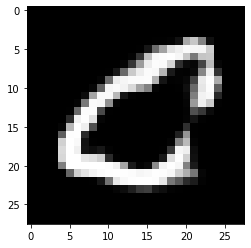

(94372, 28, 28, 1)
(94372,)
(94372, 10)


In [19]:
import numpy as np 
import matplotlib.pyplot as plt

# load mnist_adv dataset
# adv_path = 'assets/data/mnist_adv/'
adv_path = 'assets/mnist_zico_defense_by_attack_with_z0/'
adv_files = []
unrestricted_img = []
unrestricted_label = []

# for loop to load all the images
for source in range(10):
    for target in range(10):
        if(source != target):
            file = np.load(adv_path + 'from' + str(source) + 'to' + str(target) + '.npz')
            adv_files.append(file)
            unrestricted_label.extend(np.full(len(file['adv_imgs']), source).tolist())

keys = adv_files[0].files

for file in adv_files:
    with file as data:
        unrestricted_img.extend(data[keys[0]])

unrestricted_img = np.array(unrestricted_img)
unrestricted_label = np.array(unrestricted_label)
y_one_hot = np.take(np.eye(10), unrestricted_label, axis=0)

plt.imshow(unrestricted_img[0], cmap='gray')
plt.show()
print(unrestricted_img.shape)
print(unrestricted_label.shape)
print(y_one_hot.shape)

### MIM

In [20]:
# load images and labels
# import adversarial sampels
mim_images = np.load('assets/mim_images_zico.npz')['images']
mim_labels = np.load('assets/mim_images_zico.npz')['labels']
mim_labels_onehot = np.take(np.eye(10), mim_labels.astype(np.int64), axis=0)
mim_labels_onehot = mim_labels_onehot.reshape(-1, 10)

# reshape images to 28, 28, 1
mim_images = np.reshape(mim_images, (len(mim_images), 28, 28, 1))

print(mim_images.shape)
print(mim_labels.shape)
print(mim_labels_onehot.shape)

(400, 28, 28, 1)
(400, 1)
(400, 10)


## Generate Attacks
(for attacks that have not been generated and saved locally)

### MIM (using cleverhans)

In [ ]:
from cleverhans.tf2.attacks.momentum_iterative_method import momentum_iterative_method
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()

# Define the input placeholder
x_0 = tf.convert_to_tensor(np.array([train_images[0]]), dtype='float32')
y_0 = tf.convert_to_tensor(np.array(train_labels[0]), dtype='float32')

# Define the logits of the model
logits_model = tf.keras.Model(model.input,model.layers[-1].output)


# Define the attack parameters
eps = 0.5
eps_iter = 0.01
nb_iter = 40
clip_min = 0.0
clip_max = 1.0

# Generate adversarial examples
adv_x = momentum_iterative_method(logits_model, x = x_0, eps = eps, nb_iter = nb_iter, clip_min=clip_min, clip_max=clip_max, sanity_checks=False)

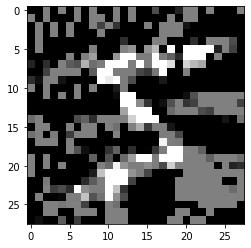

5.0

In [32]:
adv_x_image = tf.keras.backend.get_value(adv_x)
adv_x_image = np.reshape(adv_x_image, (28, 28, 1))

plt.imshow(adv_x_image, cmap='gray')
plt.show()
tf.keras.backend.get_value(y_0)

In [36]:
preds_adv_2 = model_adv(adv_x)
tf.keras.backend.get_value(tf.argmax(preds_adv_2, axis=-1))[0]

In [38]:
test_images_gen = test_images[:100]
test_labels_gen = test_labels[:100]
unique, counts = np.unique(test_labels_gen, return_counts=True)
print(np.asarray((unique, counts)))

[[ 0  1  2  3  4  5  6  7  8  9]
 [ 8 14  8 11 14  7 10 15  2 11]]


In [40]:
# calculate error rate for FGSM attack on both clean and adv model with varying epsilon values

# iterate from 0.1 to 1.5 with 0.1 step size
epsilon_values = np.arange(0.1, 0.4, 0.1)
mim_images = []
mim_labels = []

print(test_images_gen.shape)

for index, epsilon in enumerate(epsilon_values):
    print(epsilon)

    # original image and original label

    for i in range(test_images_gen.shape[0]): 
        original_image = test_images_gen[i]
        original_image = tf.convert_to_tensor(original_image.reshape((1,28,28)), dtype='float32') #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor

        original_label = test_labels_gen[i]
        original_label = np.reshape(original_label, (1,)).astype('float32') # Give label proper shape and type for cleverhans

        
        # perform spsa on train_images
        adv_example = momentum_iterative_method(logits_model, x = original_image, eps = epsilon, nb_iter = 10, clip_min=0.0, clip_max=1.0, sanity_checks=False)
        adv_example = tf.keras.backend.get_value(adv_example)
        
        # add fgsm image to list
        mim_images.append(adv_example)
        mim_labels.append(original_label)

np.savez('mim_images_zico', images=mim_images, labels=mim_labels)

(100, 28, 28)
0.1
0.2
0.30000000000000004
0.4


### PGD (ε ≃ 0.7) 

### Carlini Wagner

In [34]:
from cleverhans.tf2.attacks.carlini_wagner_l2 import carlini_wagner_l2
import tensorflow.compat.v1 as tf

# tf.enable_eager_execution()

# Define the input placeholder
x_0 = tf.convert_to_tensor(np.array([train_images[0]]), dtype='float32')
y_0 = tf.convert_to_tensor(np.array(train_labels[0]), dtype='float32')

# Define the logits of the model
logits_model = tf.keras.Model(model.input,model.layers[-1].output)

# Generate adversarial examples
adv_x = carlini_wagner_l2(logits_model, x = x_0, learning_rate=0.1, max_iterations=100, initial_const=0, binary_search_steps=50, confidence=20)

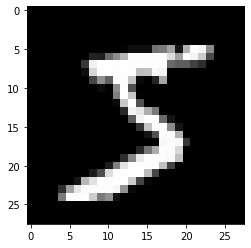

5.0

In [35]:
adv_x_image = tf.keras.backend.get_value(adv_x)
adv_x_image = np.reshape(adv_x_image, (28, 28, 1))

plt.imshow(adv_x_image, cmap='gray')
plt.show()
tf.keras.backend.get_value(y_0)

In [40]:
preds_adv_2 = model(adv_x)
tf.keras.backend.get_value(tf.argmax(preds_adv_2, axis=-1))[0]

5

## Test attack on Models

### Test on FGSM

In [12]:
print('model accuracy: %.3f' % model.evaluate(fgsm_images_zico, fgsm_labels_zico, verbose=0)[1])
print('model_madry accuracy: %.3f' % model_madry.evaluate(fgsm_images_zico, fgsm_labels_zico, verbose=0)[1])
print('model_adv accuracy: %.3f' % model_adv.evaluate(fgsm_images_zico, fgsm_labels_zico, verbose=0)[1])
print('model_adv_v2 accuracy: %.3f' % model_adv_v2.evaluate(fgsm_images_zico, fgsm_labels_zico, verbose=0)[1])
print('model_adv_v3 accuracy: %.3f' % model_adv_v3.evaluate(fgsm_images_zico, fgsm_labels_zico, verbose=0)[1])
print('model_adv_v3_2 accuracy: %.3f' % model_adv_v3_2.evaluate(fgsm_images_zico, fgsm_labels_zico, verbose=0)[1])
print('model_adv_v4 accuracy: %.3f' % model_adv_v4.evaluate(fgsm_images_zico, fgsm_labels_zico, verbose=0)[1])
print('model_adv_v5 accuracy: %.3f' % model_adv_v5.evaluate(fgsm_images_zico, fgsm_labels_zico, verbose=0)[1])
print('model_adv_v6 accuracy: %.3f' % model_adv_v6.evaluate(fgsm_images_zico, fgsm_labels_zico, verbose=0)[1])

model accuracy: 0.153
model_madry accuracy: 0.974
model_adv accuracy: 0.984
model_adv_v2 accuracy: 0.977
model_adv_v3 accuracy: 0.986
model_adv_v3_2 accuracy: 0.871
model_adv_v4 accuracy: 0.985
model_adv_v5 accuracy: 0.985
model_adv_v6 accuracy: 0.984


In [36]:
for key in adv_models_mu:
    print("Model %s: %.3f" % (key, adv_models_mu[key].evaluate(fgsm_images_zico, fgsm_labels_zico_onehot, verbose=0)[1]))

Model z: 0.101
Model z0: 0.101
Model z2: 0.101
Model z3: 0.984
Model z4: 0.101
Model z5: 0.113
Model z6: 0.983
Model z7: 0.101


#### With Albumentation Transformations

In [70]:
for key in adv_models_mu_transform:
    print("Model %s: %.3f" % (key, adv_models_mu_transform[key].evaluate(fgsm_images_zico, fgsm_labels_zico_onehot, verbose=0)[1]))

Model model: 0.797
Model z: 0.966
Model z0: 0.964
Model z2: 0.969
Model z3: 0.967
Model z4: 0.967
Model z5: 0.966
Model z6: 0.963
Model z7: 0.966


### Test on PGD

In [13]:
print('model accuracy: %.3f' % model.evaluate(pgd_images_zico, pgd_labels_zico, verbose=0)[1])
print('model_madry accuracy: %.3f' % model_madry.evaluate(pgd_images_zico, pgd_labels_zico, verbose=0)[1])
print('model_adv accuracy: %.3f' % model_adv.evaluate(pgd_images_zico, pgd_labels_zico, verbose=0)[1])
print('model_adv_v2 accuracy: %.3f' % model_adv_v2.evaluate(pgd_images_zico, pgd_labels_zico, verbose=0)[1])
print('model_adv_v3 accuracy: %.3f' % model_adv_v3.evaluate(pgd_images_zico, pgd_labels_zico, verbose=0)[1])
print('model_adv_v3_2 accuracy: %.3f' % model_adv_v3_2.evaluate(pgd_images_zico, pgd_labels_zico, verbose=0)[1])
print('model_adv_v4 accuracy: %.3f' % model_adv_v4.evaluate(pgd_images_zico, pgd_labels_zico, verbose=0)[1])
print('model_adv_v5 accuracy: %.3f' % model_adv_v5.evaluate(pgd_images_zico, pgd_labels_zico, verbose=0)[1])
print('model_adv_v6 accuracy: %.3f' % model_adv_v6.evaluate(pgd_images_zico, pgd_labels_zico, verbose=0)[1])

model accuracy: 0.220
model_madry accuracy: 0.985
model_adv accuracy: 0.988
model_adv_v2 accuracy: 0.985
model_adv_v3 accuracy: 0.988
model_adv_v3_2 accuracy: 0.985
model_adv_v4 accuracy: 0.988
model_adv_v5 accuracy: 0.987
model_adv_v6 accuracy: 0.986


In [37]:
for key in adv_models_mu:
    print("Model %s: %.3f" % (key, adv_models_mu[key].evaluate(pgd_images_zico, pgd_labels_zico_onehot, verbose=0)[1]))

Model z: 0.101
Model z0: 0.101
Model z2: 0.101
Model z3: 0.988
Model z4: 0.101
Model z5: 0.113
Model z6: 0.988
Model z7: 0.101


#### With Albumentation Transformations

In [72]:
for key in adv_models_mu_transform:
    print("Model %s: %.3f" % (key, adv_models_mu_transform[key].evaluate(pgd_images_zico, pgd_labels_zico_onehot, verbose=0)[1]))

Model model: 0.911
Model z: 0.971
Model z0: 0.971
Model z2: 0.974
Model z3: 0.972
Model z4: 0.971
Model z5: 0.973
Model z6: 0.971
Model z7: 0.970


### Test on SPSA

In [19]:
print('model accuracy: %.3f' % model.evaluate(spsa_images_zico, spsa_labels_zico, verbose=0)[1])
print('model_madry accuracy: %.3f' % model_madry.evaluate(spsa_images_zico, spsa_labels_zico, verbose=0)[1])
print('model_adv accuracy: %.3f' % model_adv.evaluate(spsa_images_zico, spsa_labels_zico, verbose=0)[1])
print('model_adv_v2 accuracy: %.3f' % model_adv_v2.evaluate(spsa_images_zico, spsa_labels_zico, verbose=0)[1])
print('model_adv_v3 accuracy: %.3f' % model_adv_v3.evaluate(spsa_images_zico, spsa_labels_zico, verbose=0)[1])
print('model_adv_v3_2 accuracy: %.3f' % model_adv_v3_2.evaluate(spsa_images_zico, spsa_labels_zico, verbose=0)[1])
print('model_adv_v4 accuracy: %.3f' % model_adv_v4.evaluate(spsa_images_zico, spsa_labels_zico, verbose=0)[1])
print('model_adv_v5 accuracy: %.3f' % model_adv_v5.evaluate(spsa_images_zico, spsa_labels_zico, verbose=0)[1])
print('model_adv_v6 accuracy: %.3f' % model_adv_v6.evaluate(spsa_images_zico, spsa_labels_zico, verbose=0)[1])

model accuracy: 0.377
model_madry accuracy: 0.965
model_adv accuracy: 0.980
model_adv_v2 accuracy: 0.983
model_adv_v3 accuracy: 0.980
model_adv_v3_2 accuracy: 0.947
model_adv_v4 accuracy: 0.985
model_adv_v5 accuracy: 0.983
model_adv_v6 accuracy: 0.980


In [38]:
for key in adv_models_mu:
    print("Model %s: %.3f" % (key, adv_models_mu[key].evaluate(spsa_images_zico, spsa_labels_zico_onehot, verbose=0)[1]))

Model z: 0.110
Model z0: 0.110
Model z2: 0.110
Model z3: 0.993
Model z4: 0.110
Model z5: 0.140
Model z6: 0.998
Model z7: 0.110


#### With Albumentation Transformations

In [74]:
for key in adv_models_mu_transform:
    print("Model %s: %.3f" % (key, adv_models_mu_transform[key].evaluate(spsa_images_zico, spsa_labels_zico_onehot, verbose=0)[1]))

Model model: 0.505
Model z: 0.952
Model z0: 0.980
Model z2: 0.978
Model z3: 0.952
Model z4: 0.955
Model z5: 0.978
Model z6: 0.967
Model z7: 0.955


### Test on MIM

In [24]:
print('model accuracy: %.3f' % model.evaluate(mim_images, mim_labels, verbose=0)[1])
print('model_madry accuracy: %.3f' % model_madry.evaluate(mim_images, mim_labels, verbose=0)[1])
print('model_adv accuracy: %.3f' % model_adv.evaluate(mim_images, mim_labels, verbose=0)[1])
print('model_adv_v2 accuracy: %.3f' % model_adv_v2.evaluate(mim_images, mim_labels, verbose=0)[1])
print('model_adv_v3 accuracy: %.3f' % model_adv_v3.evaluate(mim_images, mim_labels, verbose=0)[1])
print('model_adv_v3_2 accuracy: %.3f' % model_adv_v3_2.evaluate(mim_images, mim_labels, verbose=0)[1])
print('model_adv_v4 accuracy: %.3f' % model_adv_v4.evaluate(mim_images, mim_labels, verbose=0)[1])
print('model_adv_v5 accuracy: %.3f' % model_adv_v5.evaluate(mim_images, mim_labels, verbose=0)[1])
print('model_adv_v6 accuracy: %.3f' % model_adv_v6.evaluate(mim_images, mim_labels, verbose=0)[1])
# print('model_final accuracy: %.3f' % model_final.evaluate(mim_images, mim_labels, verbose=0)[1])

model accuracy: 0.157
model_madry accuracy: 0.935
model_adv accuracy: 0.947
model_adv_v2 accuracy: 0.848
model_adv_v3 accuracy: 0.925
model_adv_v3_2 accuracy: 0.892
model_adv_v4 accuracy: 0.925
model_adv_v5 accuracy: 0.938
model_adv_v6 accuracy: 0.940


In [39]:
for key in adv_models_mu:
    print("Model %s: %.3f" % (key, adv_models_mu[key].evaluate(mim_images, mim_labels_onehot, verbose=0)[1]))

Model z: 0.110
Model z0: 0.110
Model z2: 0.110
Model z3: 0.942
Model z4: 0.110
Model z5: 0.140
Model z6: 0.955
Model z7: 0.110


#### With Albumentation Transformations

In [76]:
for key in adv_models_mu_transform:
    print("Model %s: %.3f" % (key, adv_models_mu_transform[key].evaluate(mim_images, mim_labels_onehot, verbose=0)[1]))

Model model: 0.377
Model z: 0.940
Model z0: 0.965
Model z2: 0.960
Model z3: 0.935
Model z4: 0.947
Model z5: 0.967
Model z6: 0.965
Model z7: 0.952


### Test on BIM

In [100]:
print('model accuracy: %.3f' % model.evaluate(bim_images, bim_labels, verbose=0)[1])
print('model_madry accuracy: %.3f' % model_madry.evaluate(bim_images, bim_labels, verbose=0)[1])
print('model_adv accuracy: %.3f' % model_adv.evaluate(bim_images, bim_labels, verbose=0)[1])
print('model_adv_v2 accuracy: %.3f' % model_adv_v2.evaluate(bim_images, bim_labels, verbose=0)[1])
print('model_adv_v3 accuracy: %.3f' % model_adv_v3.evaluate(bim_images, bim_labels, verbose=0)[1])
print('model_adv_v3_2 accuracy: %.3f' % model_adv_v3_2.evaluate(bim_images, bim_labels, verbose=0)[1])
print('model_adv_v4 accuracy: %.3f' % model_adv_v4.evaluate(bim_images, bim_labels, verbose=0)[1])
print('model_adv_v5 accuracy: %.3f' % model_adv_v5.evaluate(bim_images, bim_labels, verbose=0)[1])
print('model_adv_v6 accuracy: %.3f' % model_adv_v6.evaluate(bim_images, bim_labels, verbose=0)[1])
# print('model_final accuracy: %.3f' % model_final.evaluate(bim_images, bim_labels, verbose=0)[1])

model accuracy: 0.980
model_madry accuracy: 0.717
model_adv accuracy: 0.986
model_adv_v2 accuracy: 0.979
model_adv_v3 accuracy: 0.985
model_adv_v3_2 accuracy: 0.758
model_adv_v4 accuracy: 0.985
model_adv_v5 accuracy: 0.989
model_adv_v6 accuracy: 0.984
model_final accuracy: 0.985


In [40]:
for key in adv_models_mu:
    print("Model %s: %.3f" % (key, adv_models_mu[key].evaluate(bim_images, bim_labels_onehot, verbose=0)[1]))

Model z: 0.101
Model z0: 0.101
Model z2: 0.101
Model z3: 0.988
Model z4: 0.101
Model z5: 0.113
Model z6: 0.985
Model z7: 0.101


#### With Albumentation Transformations

In [78]:
for key in adv_models_mu_transform:
    print("Model %s: %.3f" % (key, adv_models_mu_transform[key].evaluate(bim_images, bim_labels_onehot, verbose=0)[1]))

Model model: 0.371
Model z: 0.941
Model z0: 0.943
Model z2: 0.951
Model z3: 0.950
Model z4: 0.952
Model z5: 0.938
Model z6: 0.964
Model z7: 0.954


### Test on Unrestrcited Attack

## Final Training on Multiple version images

In [90]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [91]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [92]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [93]:
# load mnist dataset
ds_train_images = []
ds_train_labels = []

for images, labels in ds_train.unbatch():
  ds_train_images.append(images)
  ds_train_labels.append(labels)

ds_train_images = np.array(ds_train_images)
ds_train_labels = np.array(ds_train_labels)

In [94]:
# load mnist dataset
ds_test_images = []
ds_test_labels = []

for images, labels in ds_test.unbatch():
  ds_test_images.append(images)
  ds_test_labels.append(labels)

ds_test_images = np.array(ds_test_images)
ds_test_labels = np.array(ds_test_labels)

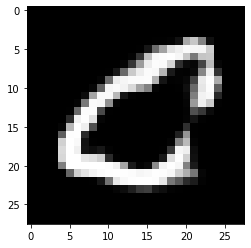

(127917, 28, 28, 1)
(127917,)


In [95]:
# load mnist_adv dataset
# adv_path = 'assets/data/mnist_adv/'
adv_paths = ['research/mnist_zico_defense_by_attack_with_z0/', 'research/mnist_zico_defense_by_attack_with_z3/', 'research/mnist_zico_defense_by_attack_with_z5/', 'research/mnist_zico_defense_by_attack_with_z6/']
adv_files = []
X = []
y = []

# for loop to load all the images
for path in adv_paths: 
  for source in range(10):
      for target in range(10):
          if(source != target):
            file = np.load(path + 'from' + str(source) + 'to' + str(target) + '.npz')
            adv_files.append(file)
            y.extend(np.full(len(file['adv_imgs']), source).tolist())

keys = adv_files[0].files

for file in adv_files:
  with file as data:
      X.extend(data[keys[0]])

X = np.array(X)
y = np.array(y)
y_one_hot = np.take(np.eye(10), y, axis=0)

plt.imshow(X[0], cmap='gray')
plt.show()
print(X.shape)
print(y.shape)

In [96]:
# split X into 70-30 train-test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [97]:
print(X_train.shape, ds_train_images.shape)

ds_train_adv_images = np.concatenate((ds_train_images, X_train), axis=0)
ds_train_adv_labels = np.concatenate((ds_train_labels, y_train), axis=0)

print(ds_train_adv_images.shape, ds_train_adv_labels.shape)

(89541, 28, 28, 1) (60000, 28, 28, 1)
(149541, 28, 28, 1) (149541,)


In [98]:
print(X_test.shape, ds_test_images.shape)

ds_test_adv_images = np.concatenate((ds_test_images, X_test), axis=0)
ds_test_adv_labels = np.concatenate((ds_test_labels, y_test), axis=0)

print(ds_test_adv_images.shape, ds_test_adv_labels.shape)


(38376, 28, 28, 1) (10000, 28, 28, 1)
(48376, 28, 28, 1) (48376,)


In [99]:
# sequential model with conv2d 16, padding valid, relu -> conv2d 32, padding valid, relu -> softmax
model_final = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, kernel_size=4, padding='valid', activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, kernel_size=4, padding='valid', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

# train on mnist
model_final.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
model_final.fit(
    x = ds_train_adv_images,
    y = ds_train_adv_labels,
    epochs=10,
    shuffle=True
)
model_final.evaluate(ds_test_adv_images, ds_test_adv_labels)


Epoch 1/10
4674/4674 [==============================] - 23s 5ms/step - loss: 0.0679 - accuracy: 0.9807
Epoch 2/10
4674/4674 [==============================] - 23s 5ms/step - loss: 0.0248 - accuracy: 0.9935
Epoch 3/10
4674/4674 [==============================] - 22s 5ms/step - loss: 0.0162 - accuracy: 0.9955
Epoch 4/10
4674/4674 [==============================] - 23s 5ms/step - loss: 0.0115 - accuracy: 0.9967
Epoch 5/10
4674/4674 [==============================] - 22s 5ms/step - loss: 0.0082 - accuracy: 0.9976
Epoch 6/10
4674/4674 [==============================] - 23s 5ms/step - loss: 0.0060 - accuracy: 0.9982
Epoch 7/10
4674/4674 [==============================] - 23s 5ms/step - loss: 0.0056 - accuracy: 0.9983
Epoch 8/10
4674/4674 [==============================] - 22s 5ms/step - loss: 0.0045 - accuracy: 0.9985
Epoch 9/10
4674/4674 [==============================] - 23s 5ms/step - loss: 0.0039 - accuracy: 0.9987
Epoch 10/10
1512/1512 [==============================] - 5s 3ms/step - lo

[0.021485043689608574, 0.9958657026290894]

In [78]:
# save model_adv
model_final.save('research/models/mnist_adv_model_final.h5')